### imports

In [35]:
# imports for the TrainingMonitor class
from keras.callbacks import BaseLogger
import matplotlib.pyplot as plt
import numpy as np
import json
import os

from keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from keras.models import Sequential
import keras.backend as k

### training monitor

In [44]:
class TrainingMonitor(BaseLogger):
  def __init__(self, total_epochs, figPath, jsonPath=None, startAt=0):
    super(TrainingMonitor, self).__init__()
    self.figPath = figPath
    self.jsonPath = jsonPath
    self.startAt = startAt
    self.firstrun = True
    self.total_epochs = total_epochs

    # for plotting
    plt.style.use("ggplot")
    self.fig, self.ax = plt.subplots(constrained_layout=True, figsize=(6,4))
    self.ax.set_xlabel("Epoch #")
    self.ax.set_ylabel("Loss/Accuracy")
    self.hdisplay = display(display_id=True)

  def on_train_begin(self, logs={}):
    self.H = {}

    if self.jsonPath is not None:
      if os.path.exists(self.jsonPath):
        self.H = json.loads(open(self.jsonPath).read())

        if self.startAt > 0:
          for k in self.H.keys():
            self.H[k] = self.H[k][:self.startAt]

  def on_epoch_end(self, epoch, logs={}):
    for (k, v) in logs.items():
      l = self.H.get(k, [])
      l.append(v)
      self.H[k] = l

    if self.jsonPath is not None:
      f = open(self.jsonPath, "w")
      f.write(json.dumps(self.H))
      f.close()
    
    if len(self.H["loss"]) > 1:
      N = np.arange(0, len(self.H["loss"]))

      self.ax.cla()      
      self.ax.plot(N, self.H["loss"], 'r-', label="train_loss")
      self.ax.plot(N, self.H["val_loss"], 'b-', label="val_loss")
      self.ax.plot(N, self.H["accuracy"], 'g-', label="train_accuracy")
      self.ax.plot(N, self.H["val_accuracy"], 'y-', label="val_accuracy")
      self.fig.suptitle("Training Loss and Accuracy [Epoch {}]".format(len(self.H["loss"])))

      self.fig.legend(bbox_to_anchor=(1.05, 0.9), loc='upper left', borderaxespad=0.)

      self.hdisplay.update(self.fig)
      self.fig.savefig(self.figPath)
   
      if epoch+1 == self.total_epochs:
        plt.close(self.fig)
    

### model

In [37]:
class MiniVGGNet:
  @staticmethod
  def build(width, height, depth, classes):
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    # if we are using "channels first", update the input shape
    # and channels dimension
    if k.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
      chanDim = 1

    # first CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # second CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))
    # return the constructed network architecture
    return model

In [38]:
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import SGD
from keras.datasets import cifar10

In [39]:
print("[INFO] process ID: {}".format(os.getpid()))

[INFO] process ID: 1824


In [40]:
print("[INFO] loading cifar-10 data...")
(trainX, trainY), (testX, testY) = cifar10.load_data()
trainX = trainX.astype('float') / 255.0
testX = testX.astype('float') / 255.0

lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

[INFO] loading cifar-10 data...


In [41]:
print("[INFO] compiling model..")
opt = SGD(lr=0.01, momentum=0.9, nesterov=True)
model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model..


### train call

In [42]:
!mkdir ./output
!rm ./output/*.json

mkdir: cannot create directory ‘./output’: File exists


[INFO] training network...
Epoch 1/3
782/782 [==============================] - 6s 8ms/step - loss: 0.8696 - accuracy: 0.6969 - val_loss: 0.7731 - val_accuracy: 0.7291


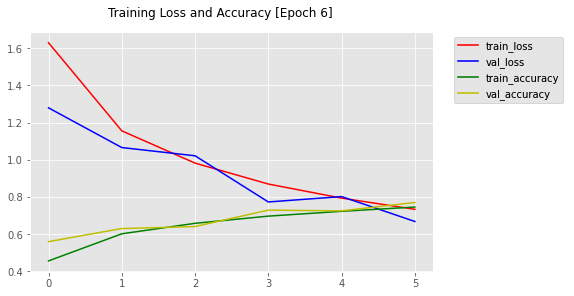

Epoch 2/3
782/782 [==============================] - 6s 8ms/step - loss: 0.7938 - accuracy: 0.7227 - val_loss: 0.8020 - val_accuracy: 0.7253
Epoch 3/3
782/782 [==============================] - 6s 8ms/step - loss: 0.7336 - accuracy: 0.7458 - val_loss: 0.6680 - val_accuracy: 0.7703


In [45]:
total_epochs = 3
figPath = os.path.sep.join(["./output", "{}.png".format(os.getpid())])
jsonPath = os.path.sep.join(["./output", "{}.json".format(os.getpid())])
callbacks = [ TrainingMonitor(figPath=figPath, jsonPath=jsonPath, total_epochs=total_epochs) ]

print("[INFO] training network...")
model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=64, epochs=total_epochs, verbose=1, callbacks=callbacks)